In [1]:
#Imports
import re

import unicodedata
import nltk
from wordcloud import WordCloud

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from env import get_db_url
import wrangle as w

1. Spam Data

a. Load the spam data set.


In [2]:
#Get SQL database url
url = get_db_url('spam_db')

#Define SQL query
query = '''
        SELECT *
        FROM spam
        '''

#Read SQL
df = pd.read_sql(query, url)
df.head()

,id,label,text
0,0,ham,"Go until jurong point, crazy.. Available only ..."
1,1,ham,Ok lar... Joking wif u oni...
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,3,ham,U dun say so early hor... U c already then say...
4,4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', '4', 'ltgt']

def clean(text):
    '''
    A simple function to cleanup text data.
    
    Args:
        text (str): The text to be cleaned.
        
    Returns:
        list: A list of lemmatized words after cleaning.
    '''
    
    # basic_clean() function from last lesson:
    # Normalize text by removing diacritics, encoding to ASCII, decoding to UTF-8, and converting to lowercase
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    
    # Remove punctuation, split text into words
    words = re.sub(r'[^\w\s]', '', text).split()
    
    
    # lemmatize() function from last lesson:
    # Initialize WordNet lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    
    # Combine standard English stopwords with additional stopwords
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    
    # Lemmatize words and remove stopwords
    cleaned_words = [wnl.lemmatize(word) for word in words if word not in stopwords]
    
    return cleaned_words

b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?


In [4]:
# we can do that process with a join on a Series and not just a list
# we will do that for ham words, spam words, and all words
# we will pass our basic cleaning on top of that

ham_words = clean(" ".join(df[df.label == "ham"]["text"]))
spam_words = clean(" ".join(df[df.label == "spam"]["text"]))
all_words = clean(" ".join(df["text"]))

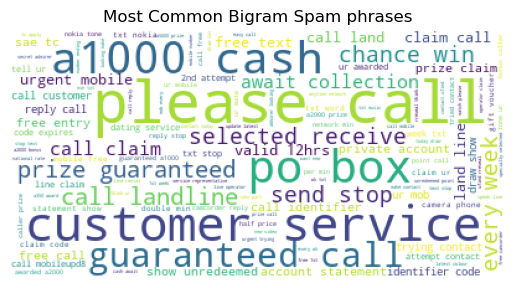

In [5]:
img = WordCloud(background_color="white", collocation_threshold = 2).generate(" ".join(spam_words))

plt.imshow(img)
plt.axis("off")
plt.title("Most Common Bigram Spam phrases")
plt.show()

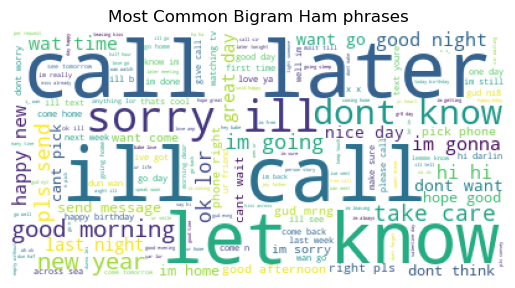

In [6]:
img = WordCloud(background_color="white", collocation_threshold = 2).generate(" ".join(ham_words))

plt.imshow(img)
plt.axis("off")
plt.title("Most Common Bigram Ham phrases")
plt.show()

c. Is there any overlap in the bigrams for the spam data and the ham data?
* not complete bigrams but words like call, later, hi


d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

<AxesSubplot:>

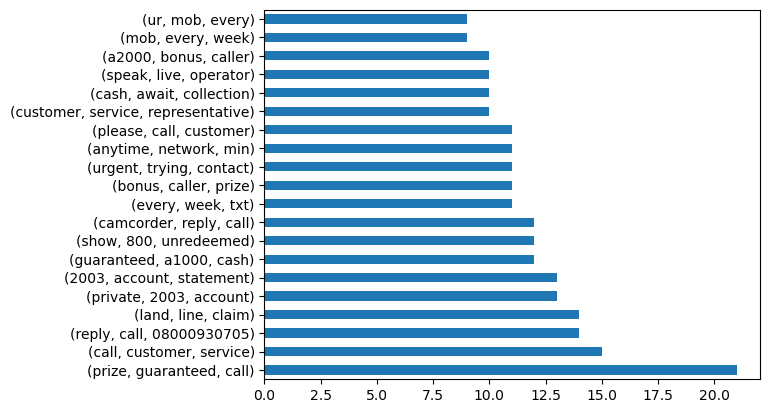

In [31]:
pd.Series(nltk.ngrams(spam_words, 3)).value_counts().head(20).plot.barh()

<AxesSubplot:>

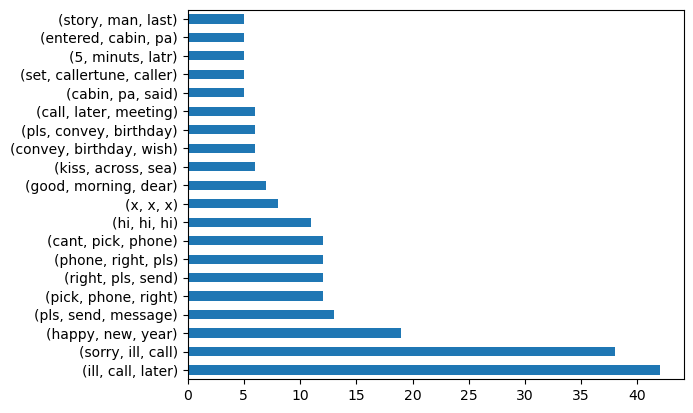

In [33]:
pd.Series(nltk.ngrams(ham_words, 3)).value_counts().head(20).plot.barh()

2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [93]:
#Import dependencies
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import re
import os
import json
#Define headers
headers = {'User-Agent': 'Codeup Data Science'}
#scrape blog homepage for links

url = "https://codeup.com/blog/"

response = get(url, headers = headers)

soup = BeautifulSoup(response.content, 'html.parser')

more_links = soup.find_all('a', class_="more-link")

links_list = [link['href'] for link in more_links]
blog = w.get_blog_articles(links_list)

In [94]:
blog = pd.DataFrame(blog)

In [95]:
blog = blog.rename(columns={"content": "original"})

In [96]:
blog = w.clean_df(blog)
blog.head()

,title,link,date_published,original,clean,stemmed,lemmatized
0,Spotlight on APIDA Voices: Celebrating Heritag...,https://codeup.com/featured/apida-heritage-month/,"May 24, 2023",\nMay is traditionally known as Asian American...,may traditionally known asian american pacific...,may tradit known asian american pacif island a...,may traditionally known asian american pacific...
1,Women in tech: Panelist Spotlight – Magdalena ...,https://codeup.com/featured/women-in-tech-pane...,"Mar 28, 2023",\nWomen in tech: Panelist Spotlight – Magdalen...,women tech panelist spotlight magdalena rahn c...,women tech panelist spotlight magdalena rahn c...,woman tech panelist spotlight magdalena rahn c...
2,Women in tech: Panelist Spotlight – Rachel Rob...,https://codeup.com/featured/women-in-tech-rach...,"Mar 20, 2023",\nWomen in tech: Panelist Spotlight – Rachel R...,women tech panelist spotlight rachel robbinsma...,women tech panelist spotlight rachel robbinsma...,woman tech panelist spotlight rachel robbinsma...
3,Women in Tech: Panelist Spotlight – Sarah Mellor,https://codeup.com/codeup-news/women-in-tech-p...,"Mar 13, 2023",\nWomen in tech: Panelist Spotlight – Sarah Me...,women tech panelist spotlight sarah mellor cod...,women tech panelist spotlight sarah mellor cod...,woman tech panelist spotlight sarah mellor cod...
4,Women in Tech: Panelist Spotlight – Madeleine ...,https://codeup.com/events/women-in-tech-madele...,"Mar 6, 2023",\nWomen in tech: Panelist Spotlight – Madelein...,women tech panelist spotlight madeleine capper...,women tech panelist spotlight madelein capper ...,woman tech panelist spotlight madeleine capper...


In [108]:
blog_words = " ".join(blog.clean).split(" ")
blog_clean_freq = pd.Series(blog_words).value_counts()

blog_words = " ".join(blog.stemmed).split(" ")
blog_stem_freq = pd.Series(blog_words).value_counts()

blog_words = " ".join(blog.lemmatized).split(" ")
blog_lem_freq = pd.Series(blog_words).value_counts()

In [109]:
blog_stem_freq.head()

codeup    27
women     18
data      17
tech      15
scienc    14
dtype: int64

In [111]:
blog_clean_freq.head()

codeup     24
data       17
tech       15
women      14
science    14
dtype: int64

In [110]:
blog_lem_freq.head()

codeup     24
woman      18
data       17
tech       15
science    14
dtype: int64

In [139]:
word_counts = pd.concat([blog_clean_freq, blog_stem_freq, blog_lem_freq], axis=1).fillna(0).astype(int)

# rename the col names
word_counts.columns = ["clean", "stem", "lemmatize"]

word_counts.head()

,clean,stem,lemmatize
codeup,24,27,24
data,17,17,17
tech,15,15,15
women,14,18,0
science,14,0,14


<AxesSubplot:>

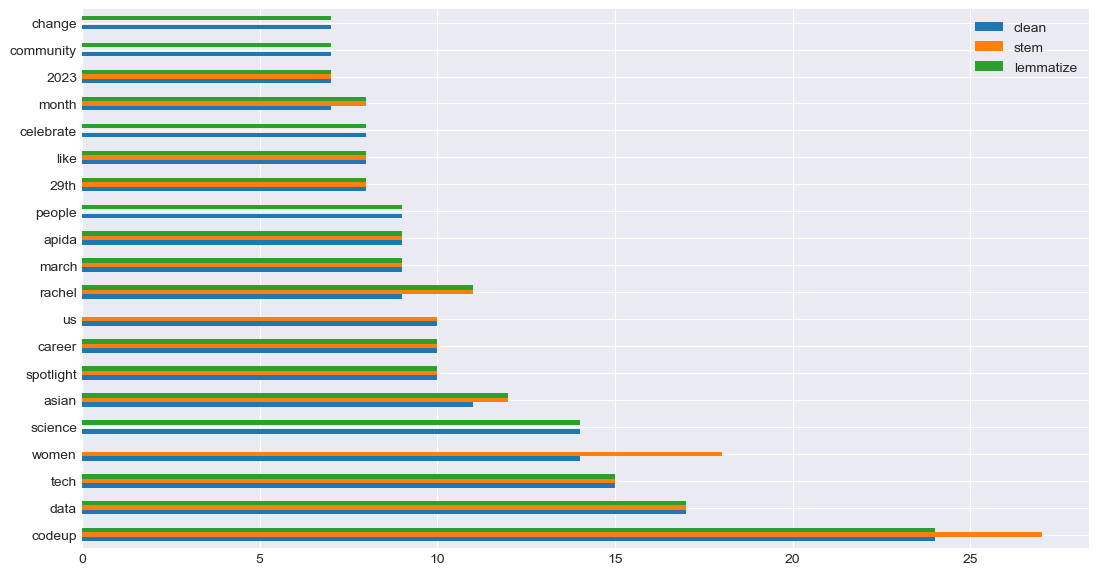

In [144]:
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')
word_counts.sort_values(["clean", "stem", "lemmatize"], ascending=False).head(20).plot.barh()

# [["clean", "stem", "lemmatize"]].head(20).plot.barh()

<AxesSubplot:>

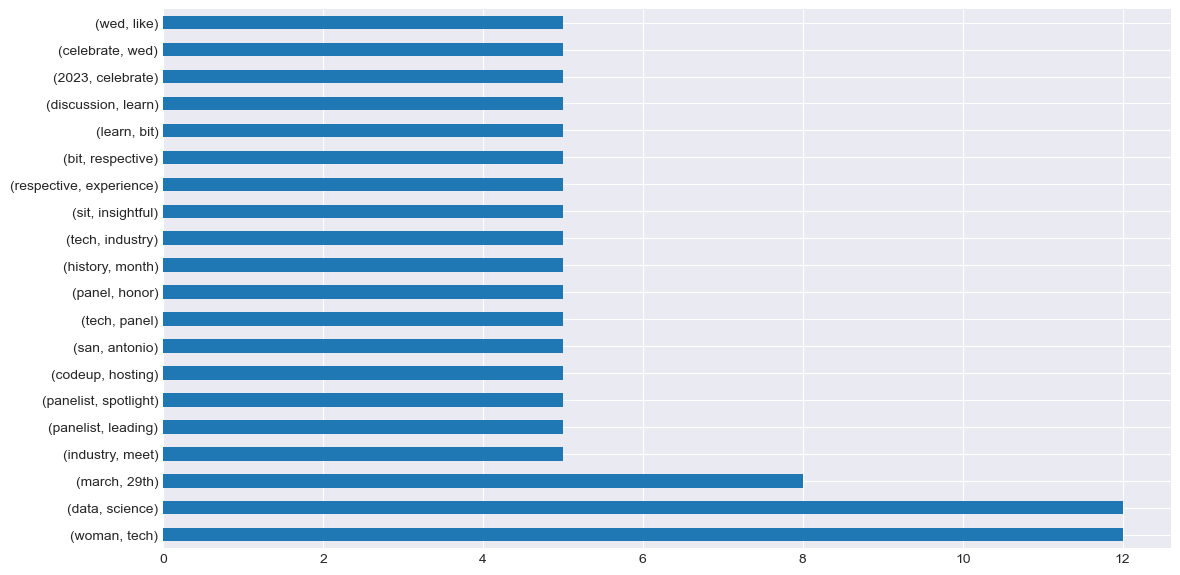

In [145]:
pd.Series(nltk.bigrams(blog_words)).value_counts().head(20).plot.barh()

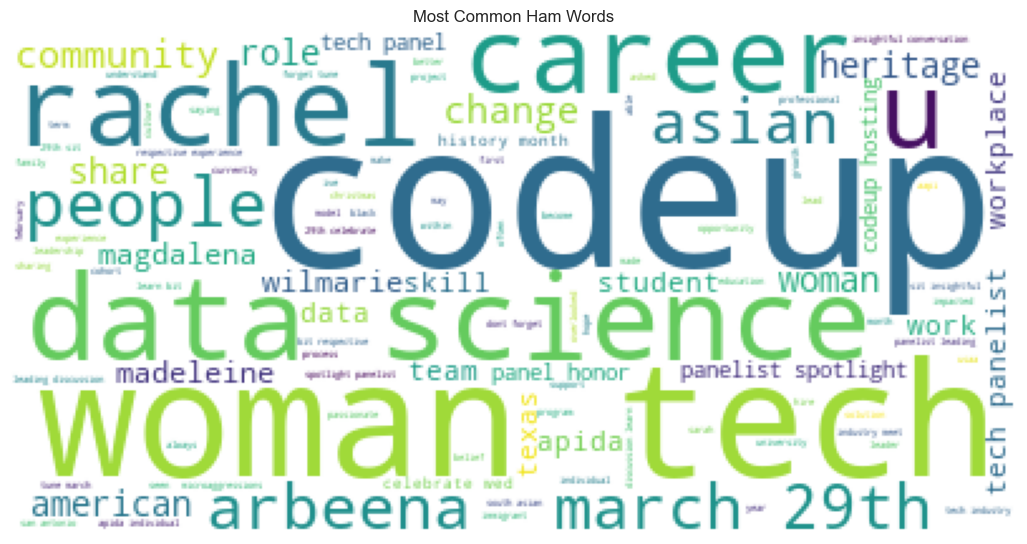

In [146]:
img = WordCloud(background_color="white").generate(" ".join(blog_words))

plt.imshow(img)
plt.axis("off")
plt.title("Most Common Ham Words")
plt.show()

In [156]:
# add two new columns 'message_length' and 'word_count'

blog["message_length"] = blog["clean"].str.len()

In [157]:
import nltk.sentiment
# we call nltk.sentiment.SentimentIntensityAnalyser()
# use polarity_scores from that object

sia = nltk.sentiment.SentimentIntensityAnalyzer()

blog['sentiment'] = blog["clean"].apply(lambda doc: sia.polarity_scores(doc)["compound"])
blog.head()

,title,link,date_published,original,clean,stemmed,lemmatized,sentiment,message_length
0,Spotlight on APIDA Voices: Celebrating Heritag...,https://codeup.com/featured/apida-heritage-month/,"May 24, 2023",\nMay is traditionally known as Asian American...,may traditionally known asian american pacific...,may tradit known asian american pacif island a...,may traditionally known asian american pacific...,0.9989,3592
1,Women in tech: Panelist Spotlight – Magdalena ...,https://codeup.com/featured/women-in-tech-pane...,"Mar 28, 2023",\nWomen in tech: Panelist Spotlight – Magdalen...,women tech panelist spotlight magdalena rahn c...,women tech panelist spotlight magdalena rahn c...,woman tech panelist spotlight magdalena rahn c...,0.9689,878
2,Women in tech: Panelist Spotlight – Rachel Rob...,https://codeup.com/featured/women-in-tech-rach...,"Mar 20, 2023",\nWomen in tech: Panelist Spotlight – Rachel R...,women tech panelist spotlight rachel robbinsma...,women tech panelist spotlight rachel robbinsma...,woman tech panelist spotlight rachel robbinsma...,0.9949,2054
3,Women in Tech: Panelist Spotlight – Sarah Mellor,https://codeup.com/codeup-news/women-in-tech-p...,"Mar 13, 2023",\nWomen in tech: Panelist Spotlight – Sarah Me...,women tech panelist spotlight sarah mellor cod...,women tech panelist spotlight sarah mellor cod...,woman tech panelist spotlight sarah mellor cod...,0.9823,942
4,Women in Tech: Panelist Spotlight – Madeleine ...,https://codeup.com/events/women-in-tech-madele...,"Mar 6, 2023",\nWomen in tech: Panelist Spotlight – Madelein...,women tech panelist spotlight madeleine capper...,women tech panelist spotlight madelein capper ...,woman tech panelist spotlight madeleine capper...,0.9749,977


In [158]:
# is the mean and median values of sentiment score different for ham vs spam?

blog.groupby('title').sentiment.agg(['mean','median'])

,mean,median
title,,
Black Excellence in Tech: Panelist Spotlight – Wilmarie De La Cruz Mejia,0.9894,0.9894
Spotlight on APIDA Voices: Celebrating Heritage and Inspiring Change ft. Arbeena Thapa,0.9989,0.9989
Women in Tech: Panelist Spotlight – Madeleine Capper,0.9749,0.9749
Women in Tech: Panelist Spotlight – Sarah Mellor,0.9823,0.9823
Women in tech: Panelist Spotlight – Magdalena Rahn,0.9689,0.9689
Women in tech: Panelist Spotlight – Rachel Robbins-Mayhill,0.9949,0.9949


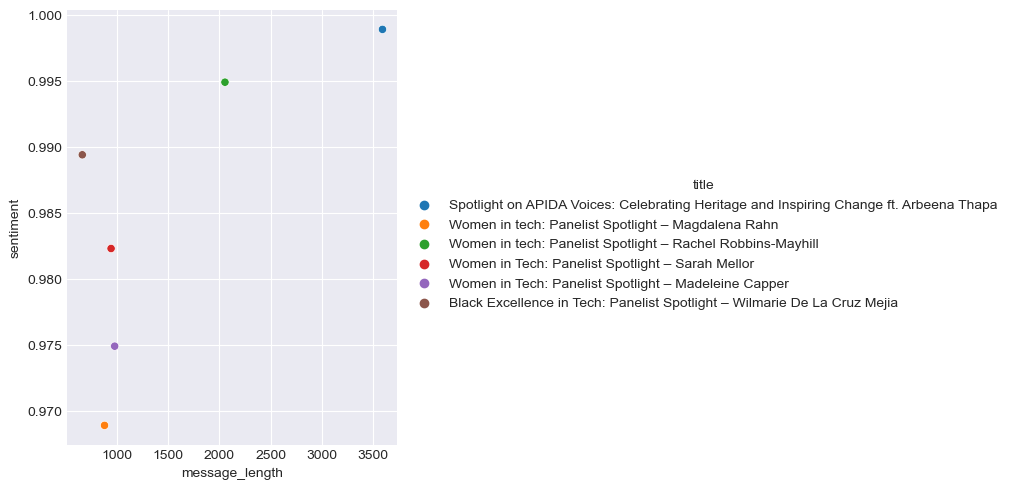

In [161]:
#plot message_length vs sentiment and hue by label

sns.relplot(data=blog, x="message_length", y="sentiment", hue="title")

In [147]:

topics = ['business', 'sports', 'technology', 'entertainment']

articles = w.get_news_articles(topics)

In [151]:
articles = pd.DataFrame(articles)
articles

,category,title,content
0,business,"Rau's IAS, Seekers Education fined for mislead...",The Central Consumer Protection Authority (CCP...
1,business,Not an endorsement: Govt on ad with Google fea...,Google's collaborative advertisement with the ...
2,business,Drone maker ideaForge's ₹567 crore IPO fully s...,The initial public offering (IPO) of India's l...
3,business,India to soon have ethanol-powered vehicles ru...,Union Minister Nitin Gadkari said that India w...
4,business,Srinagar-Jammu IndiGo flight enters Pak airspa...,A Srinagar-Jammu IndiGo flight was forced to e...
...,...,...,...
95,entertainment,'The Kerala Story' makers announce next film '...,"Director Sudipto Sen and producer Vipul Shah, ..."
96,entertainment,Story needed them: Amit on pairing Kajol with ...,Filmmaker Amit Sharma opened up about casting ...
97,entertainment,"1,000 dancers had to reshoot as Bhansali saw 1...",Sharad Kelkar shared an incident from the sets...
98,entertainment,Many are comfortable with it: Sharman Joshi on...,Sharman Joshi said that while he doesn't have ...


In [163]:
articles = articles.rename(columns={"content": "original"})

In [171]:
business_words = clean(" ".join(articles[articles.category == "business"]["original"]))
sports_words = clean(" ".join(articles[articles.category == "sports"]["original"]))
technology_words = clean(" ".join(articles[articles.category == "technology"]["original"]))
entertainment_words = clean(" ".join(articles[articles.category == "entertainment"]["original"]))
all_words = clean(" ".join(articles["original"]))

In [172]:
business_freq = pd.DataFrame(business_words).value_counts()
sports_freq = pd.DataFrame(sports_words).value_counts()
technology_freq = pd.DataFrame(technology_words).value_counts()
entertainment_freq = pd.DataFrame(entertainment_words).value_counts()
all_freq = pd.DataFrame(all_words).value_counts()

In [173]:
# lets combine all 3 dfs horizontally
# fill any missing values with zero
# convert the resulting df to contain only integer values:
word_counts = pd.concat([business_freq, sports_freq, technology_freq, entertainment_freq, all_freq], axis=1).fillna(0).astype(int)

# rename the col names
word_counts.columns = ['business', 'sports', 'technology', 'entertainment', 'all']

word_counts.head()

,business,sports,technology,entertainment,all
0,,,,,
said,21,16,23,17,77
india,14,13,15,4,46
bank,14,0,4,0,18
crore,10,0,3,1,14
company,9,1,8,0,18


In [174]:
# sort by 'all'

word_counts.sort_values("all", ascending=False)

,business,sports,technology,entertainment,all
0,,,,,
said,21,16,23,17,77
india,14,13,15,4,46
added,7,9,5,9,30
technology,6,0,12,0,18
bank,14,0,4,0,18
...,...,...,...,...,...
click,0,1,0,0,1
competition,0,1,0,0,1
constructor,0,1,0,0,1


<AxesSubplot:ylabel='0'>

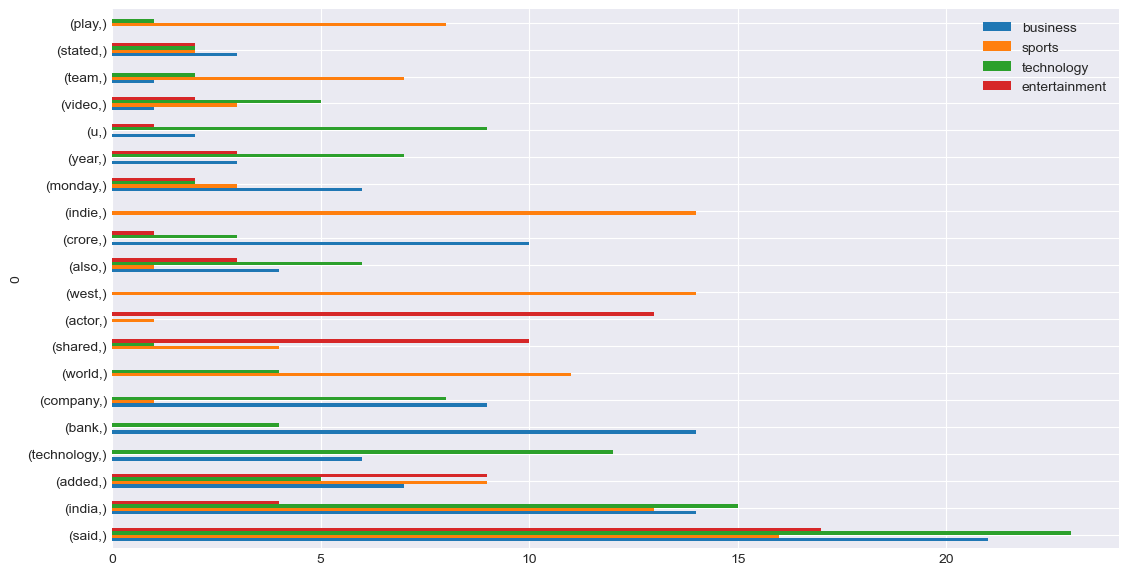

In [181]:
word_counts.sort_values( "all", ascending=False)[['business', 'sports', 'technology', 'entertainment']].head(20).plot.barh()

In [182]:
# the percentage for each category that makes up the whole(word_counts.sort_values("all", ascending=False)
 .head(20)
 .apply(lambda row: row/row["all"], axis=1)
 .drop(columns= "all")
 .sort_values(by="spam")
 .plot.barh(stacked=True, width=1, ec= "black")
)
plt.title('% of spam vs ham for the most common 20 words')
plt.legend(bbox_to_anchor=(1.2, 1.0),loc='upper right')
plt.show()
word_counts.sort_values( "all", ascending=False).head(20)\
.apply(lambda row: row/row["all"], axis=1)

,business,sports,technology,entertainment,all
0,,,,,
said,0.272727,0.207792,0.298701,0.220779,1.0
india,0.304348,0.282609,0.326087,0.086957,1.0
added,0.233333,0.300000,0.166667,0.300000,1.0
technology,0.333333,0.000000,0.666667,0.000000,1.0
bank,0.777778,0.000000,0.222222,0.000000,1.0
company,0.500000,0.055556,0.444444,0.000000,1.0
world,0.000000,0.733333,0.266667,0.000000,1.0
shared,0.000000,0.266667,0.066667,0.666667,1.0
actor,0.000000,0.071429,0.000000,0.928571,1.0


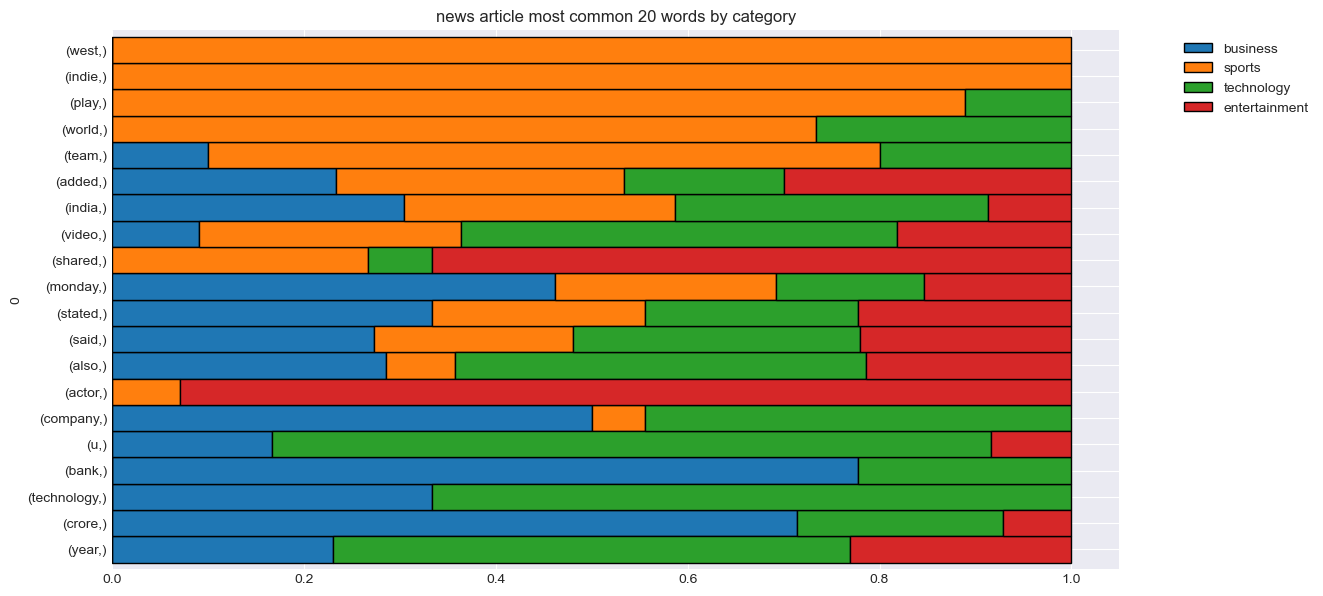

In [186]:
(word_counts.sort_values("all", ascending=False)
 .head(20)
 .apply(lambda row: row/row["all"], axis=1)
 .drop(columns= "all")
 .sort_values(by="sports")
 .plot.barh(stacked=True, width=1, ec= "black")
)
plt.title('news article most common 20 words by category')
plt.legend(bbox_to_anchor=(1.2, 1.0),loc='upper right')
plt.show()

<AxesSubplot:>

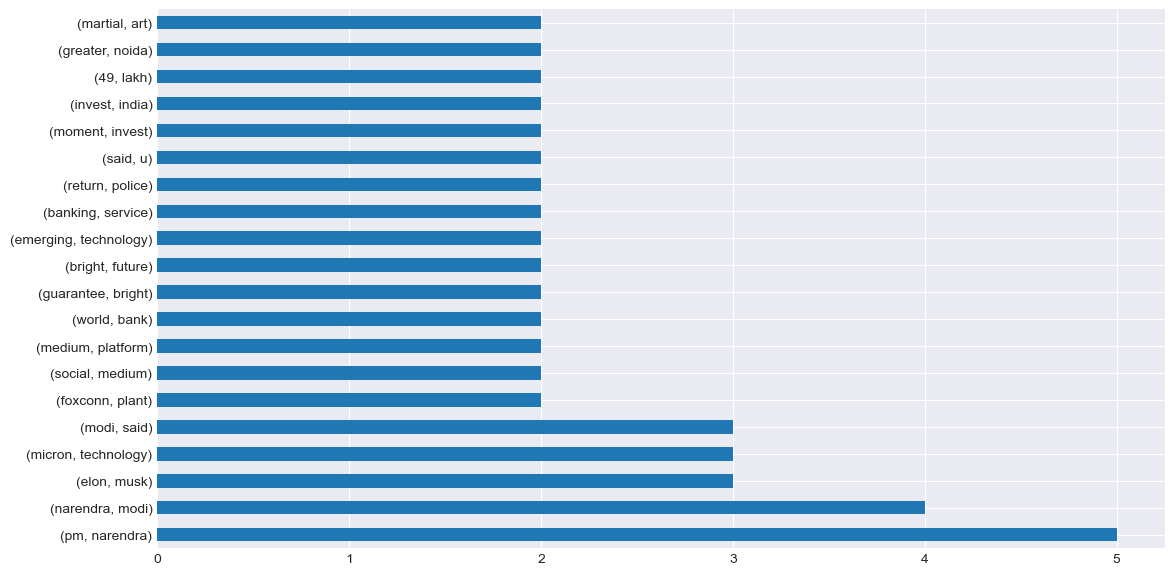

In [187]:
pd.Series(nltk.bigrams(technology_words)).value_counts().head(20).plot.barh()

<AxesSubplot:>

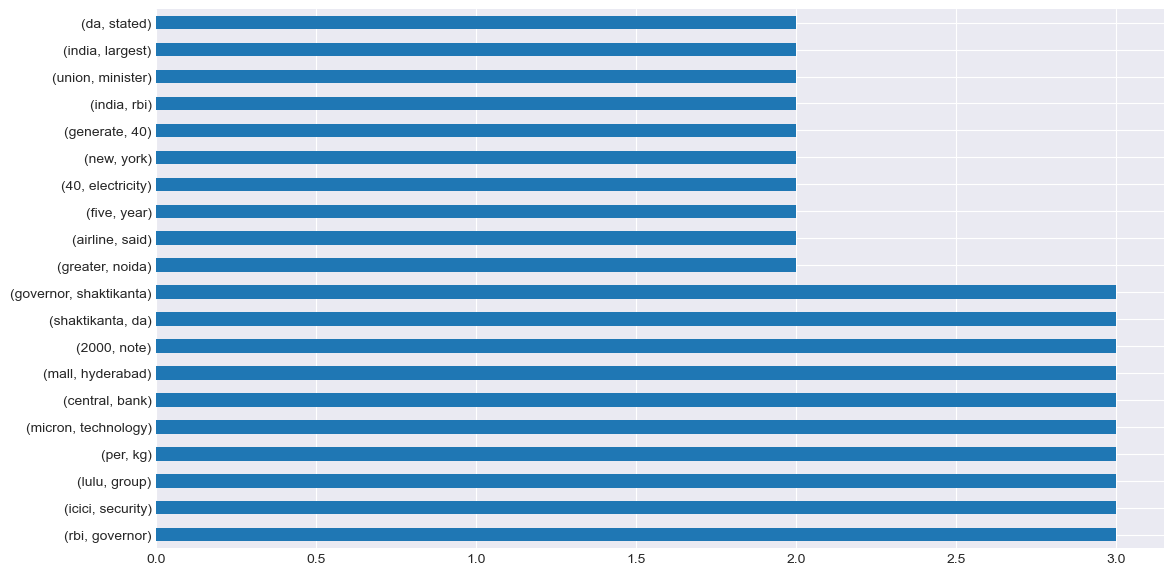

In [188]:
pd.Series(nltk.bigrams(business_words)).value_counts().head(20).plot.barh()

In [191]:
# add two new columns 'message_length' and 'word_count'

articles["message_length"] = articles["original"].str.len()

In [192]:
# grab the sentiment from each of the texts as they stand:
# apply a lambda function on each cell in the text column:
# polarity_score's value associtated with the "compound"
# key for each score

articles['sentiment'] = articles["original"].apply(lambda doc: sia.polarity_scores(doc)["compound"])
articles.head()

,category,title,original,sentiment,message_length
0,business,"Rau's IAS, Seekers Education fined for mislead...",The Central Consumer Protection Authority (CCP...,0.8020,396
1,business,Not an endorsement: Govt on ad with Google fea...,Google's collaborative advertisement with the ...,0.2589,400
2,business,Drone maker ideaForge's ₹567 crore IPO fully s...,The initial public offering (IPO) of India's l...,0.2960,357
3,business,India to soon have ethanol-powered vehicles ru...,Union Minister Nitin Gadkari said that India w...,0.0000,387
4,business,Srinagar-Jammu IndiGo flight enters Pak airspa...,A Srinagar-Jammu IndiGo flight was forced to e...,-0.7579,386


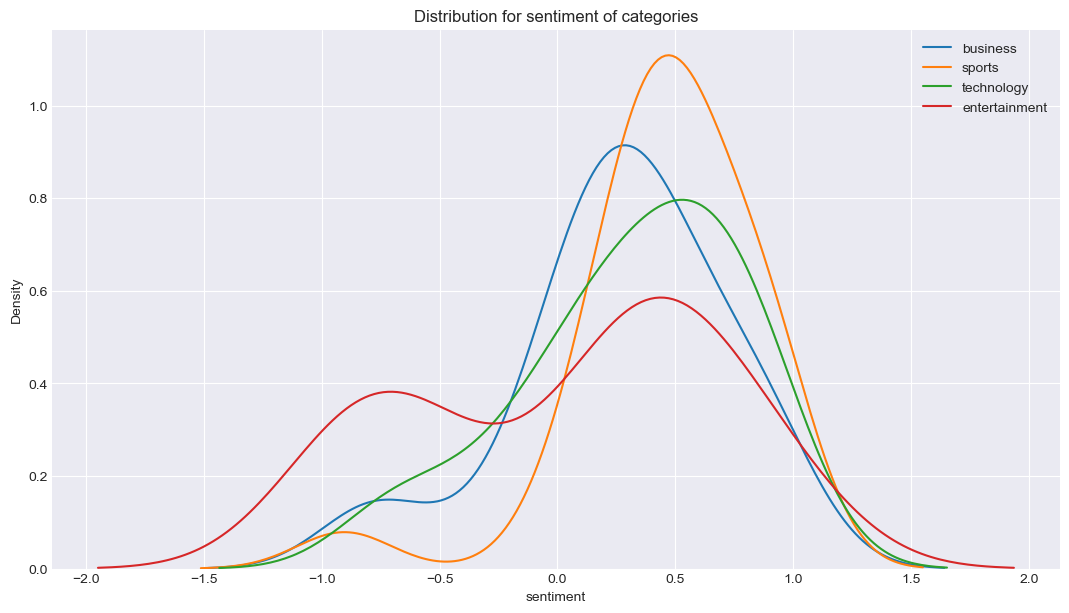

In [196]:
# is the distribution for sentiment different for cat

sns.kdeplot(articles[articles.category == "business"].sentiment, label="business")
sns.kdeplot(articles[articles.category == "sports"].sentiment, label="sports")
sns.kdeplot(articles[articles.category == "technology"].sentiment, label="technology")
sns.kdeplot(articles[articles.category == "entertainment"].sentiment, label="entertainment")
plt.legend(['business', 'sports', 'technology', 'entertainment'])
plt.title("Distribution for sentiment of categories")
plt.show()

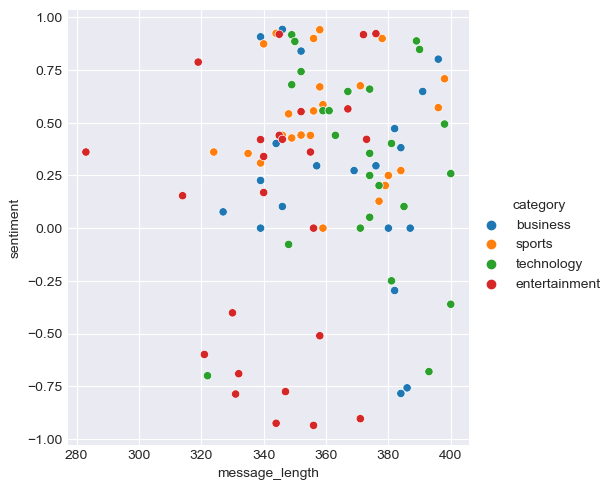

In [197]:
#plot message_length vs sentiment and hue by label

sns.relplot(data=articles, x="message_length", y="sentiment", hue="category")

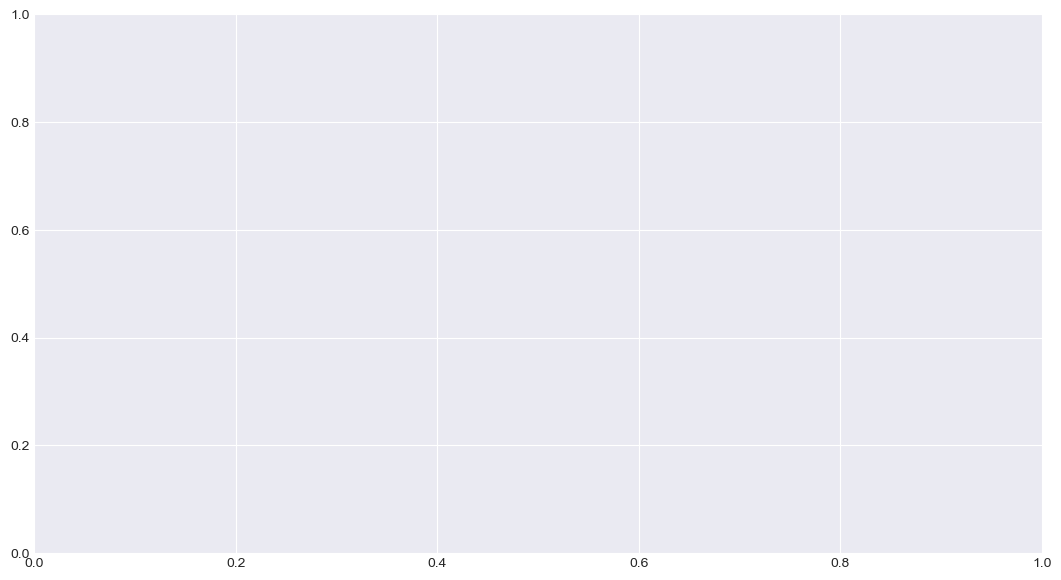

In [202]:
# Bivariate KDE plot for message_length vs sentiment score 
sns.kdeplot(
    x=articles[articles.title == 'business'].sentiment,
    y=articles[articles.title == 'business'].message_length, 
    levels = 30, shade = True, alpha=0.75);
sns.kdeplot(
    x=articles[articles.title == 'sports'].sentiment,
    y=articles[articles.title == 'sports'].message_length, 
    levels = 30, shade = True, alpha=0.75);
sns.kdeplot(
    x=articles[articles.title == 'technology'].sentiment,
    y=articles[articles.title == 'technology'].message_length, 
    levels = 30, shade = True, alpha=0.75);
sns.kdeplot(
    x=articles[articles.title == 'entertainment'].sentiment,
    y=articles[articles.title == 'entertainment'].message_length, 
    levels = 30, shade = True, alpha=0.75);
# plt.ylim(top=250)
plt.show()